<a href="https://colab.research.google.com/github/spoon-while-spoon/bike-traffic-mlpred/blob/main/ml_reg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Analyse
###Importieren der Bibliotheken

`%matplotlib inline` wird nur in der Jupyter Notebook Umgebung benötigt.
Mit `sns.set(color_codes=True)` kann das Seaborn Farbschema geändert werden

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
sns.set(color_codes=True)

### Importieren der Daten

Hier wird die csv importert welche mit dem voirherigen Skript erstellt und exportiert wurde

In [45]:
df = pd.read_csv("clean_df.csv", sep=",")
df.head (5)

,MESS_DATUM,WINDGESCHWINDIGKEIT,SONNENSCHEINDAUER,NIEDERSCHLAGSHOEHE,LUFTDRUCK_NN,LUFTTEMPERATUR,LUFTFEUCHTIGKEIT,NORD,SUED,RAD_GESAMT
0,2015-08-20 05:00:00,860.0,0.0,0,10237.0,15.0,63.0,9.0,17.0,26.0
1,2015-08-20 10:00:00,480.0,45.0,0,10244.0,24.0,30.0,506.0,607.0,1113.0
2,2015-08-20 19:00:00,420.0,0.0,0,10246.0,23.0,28.0,656.0,662.0,1318.0
3,2015-08-21 00:00:00,920.0,0.0,0,10255.0,19.0,41.0,176.0,168.0,344.0
4,2015-08-21 03:00:00,800.0,0.0,0,10255.0,17.0,49.0,54.0,28.0,82.0


### Überprüfung
Daten auf Konsistenz  und  Vollständigkeit prüfen und ggf Spalten hinzufügen die interessant sein könnten in der Asuwertung

In [29]:
df['NIEDERSCHLAGSHOEHE'] = pd.to_numeric(df['NIEDERSCHLAGSHOEHE'], errors='coerce')
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6853 entries, 0 to 6852
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MESS_DATUM           6853 non-null   datetime64[ns]
 1   WINDGESCHWINDIGKEIT  6853 non-null   float64       
 2   SONNENSCHEINDAUER    6853 non-null   float64       
 3   NIEDERSCHLAGSHOEHE   6186 non-null   float64       
 4   LUFTDRUCK_NN         6853 non-null   float64       
 5   LUFTTEMPERATUR       6853 non-null   float64       
 6   LUFTFEUCHTIGKEIT     6853 non-null   float64       
 7   NORD                 6853 non-null   float64       
 8   SUED                 6853 non-null   float64       
 9   RAD_GESAMT           6853 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 535.5 KB


In [30]:
correlation_matrix = df.corr()

<ipython-input-30-68bbfff3c4eb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


### Korrelationsmatrix

Für die erste grobe übersicht welche Daten mit welchen korrellieren bietet sich die Korrelationsmatrix an. Es gibt aber auch noch andere Wege.

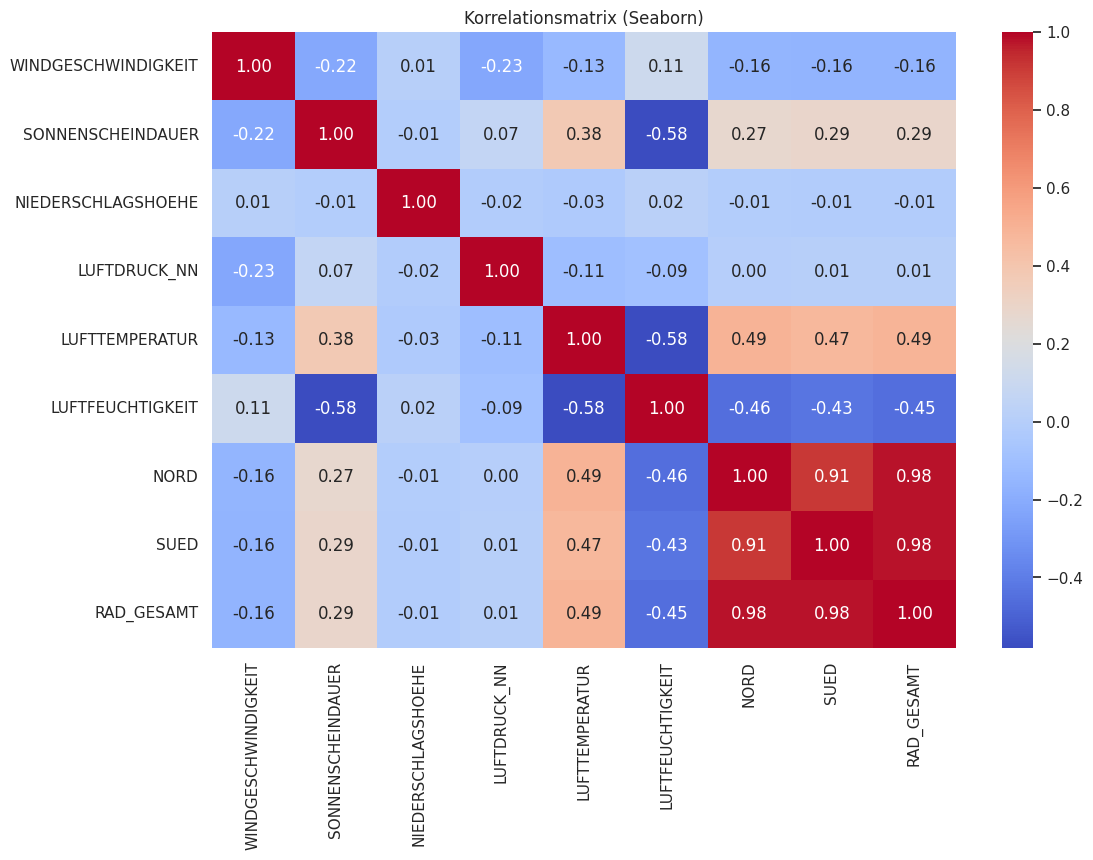

In [31]:
# Erstellung einer Heatmap zur Darstellung der Korrelationen
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix (Seaborn)")
plt.show()

### Erster Eindruck

*Auffällig sind auf jeden Fall folgende Punkte:*

> *   Es gibt eine gewisse Korrelation zwischen der **Radverkehrsnutzung** **(RAD_GESAMT) **und einigen Wetterparametern, obwohl die meisten Korrelationen nicht besonders stark sin
>
> *   **SONNENSCHEINDAUER** zeigt eine moderate positive Korrelation mit **RAD_GESAMT**, was darauf hindeuten könnte, dass mehr Menschen Rad fahren, wenn die Sonne scheint.
>
> *   Andere Wetterbedingungen wie **LUFTTEMPERATUR**, **LUFTFEUCHTIGKEIT** und **WINDGESCHWINDIGKEIT** haben ebenfalls eine gewisse, aber weniger ausgeprägte Korrelation mit dem **Radverkehr**.




*Um noch weitere Auffälligkeiten zu untersuchen und mehr unterscheidbaree Werte zu haben fügen wir noch weitere Spalten hinzu:*


> 1.   `Wochentyp` um zwischen Werktag und Wochenende unterscheiden zu können
>
> 2.   Die sperate Angabe des Monats

Anschließen überprüfen wir das ganze nochmal mit `df.head`


In [32]:
df['WOCHENTYP'] = np.where(df['MESS_DATUM'].dt.dayofweek < 5, 'Wochentag', 'Wochenende')
df['MONAT'] = df['MESS_DATUM'].dt.month

### Analysen

Als nächstest erstellen wir ein paar Diagramme um uns einen überblick zu verschaffen und einzuschätzen was wir mit unserem Training erreichen können oder wollen:

#### Boxplott
Der Boxplot zeigt die Verteilung des Radverkehrs (RAD_GESAMT) an Werktagen im Vergleich zu Wochenenden. Die Unterschiede in der Verteilung, wie Median, Quartile und Ausreißer, können hier deutlich gesehen werden.

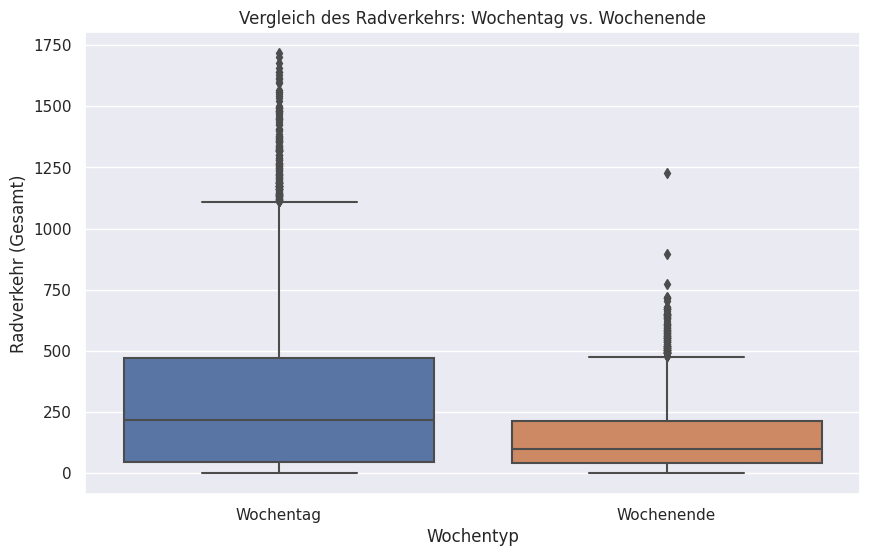

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='WOCHENTYP', y='RAD_GESAMT', data=df)
plt.title('Vergleich des Radverkehrs: Wochentag vs. Wochenende')
plt.xlabel('Wochentyp')
plt.ylabel('Radverkehr (Gesamt)')
plt.show()

####  Trend Diagramm monatlich

Das Balkendiagramm zeigt die durchschnittliche Radverkehrsnutzung pro Monat für eine grobe Einschätzung.

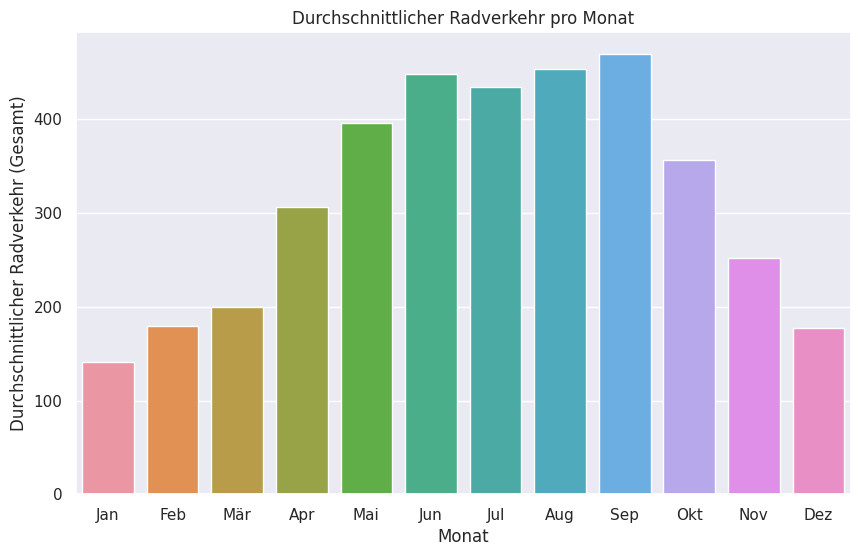

In [34]:
monthly_avg = df.groupby('MONAT')['RAD_GESAMT'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Durchschnittlicher Radverkehr pro Monat')
plt.xlabel('Monat')
plt.ylabel('Durchschnittlicher Radverkehr (Gesamt)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
plt.show()

#### Scatterplot mit Randverteilung
Diese Diagramme helfen dabei, visuelle Muster oder Trends zu erkennen.

Um gezielter die Daten zu veranschaulichen und Muster zwischen dem Wetter und der Radverkehrsnutzung zu erkennen erstellen wir als Plot:

1. Radverkehrsnutzung gegen *Sonnenstunden*
2. Radverkehrsnutzung gegen Temperatur

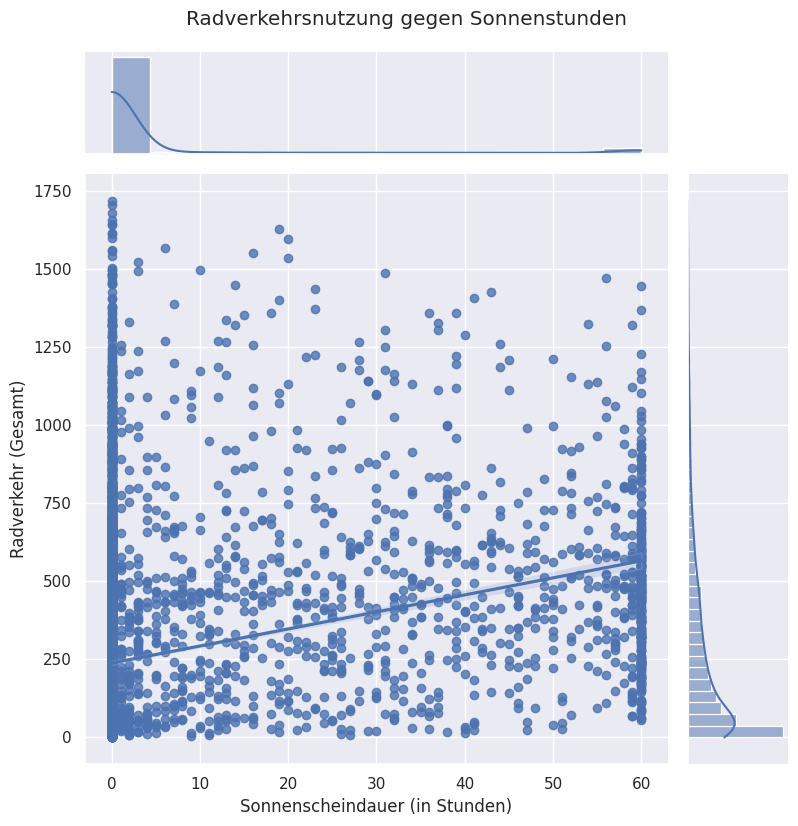

In [35]:
sns.jointplot(x='SONNENSCHEINDAUER', y='RAD_GESAMT', kind='reg', data=df, height=8)
plt.suptitle('Radverkehrsnutzung gegen Sonnenstunden', y=1.03) # Verschiebung der Überschrift nach oben
plt.xlabel('Sonnenscheindauer (in Stunden)')
plt.ylabel('Radverkehr (Gesamt)')
plt.show()

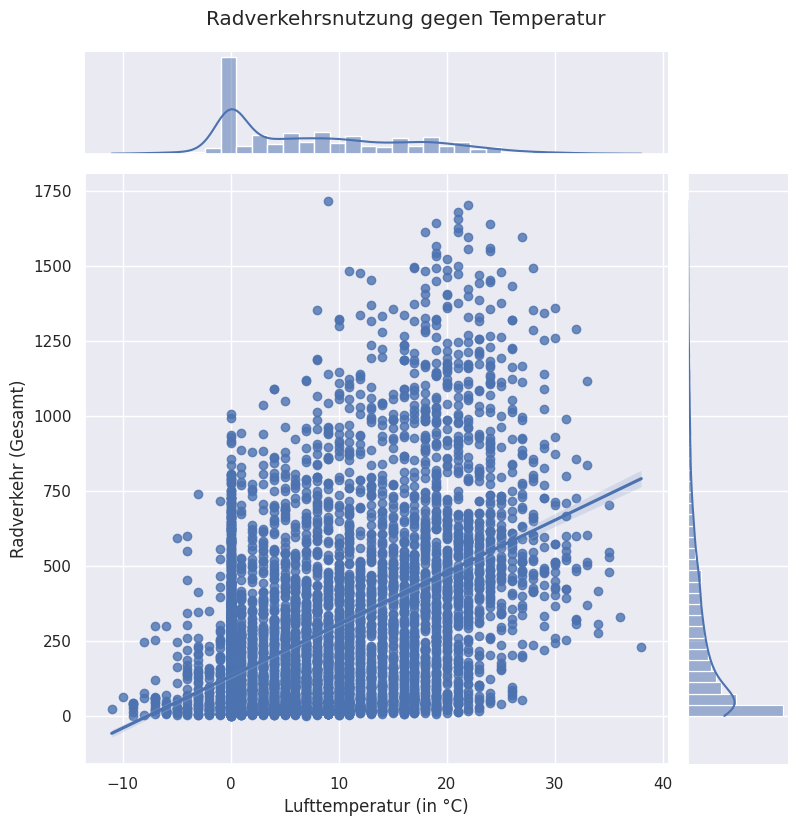

In [36]:
sns.jointplot(x='LUFTTEMPERATUR', y='RAD_GESAMT', kind='reg', data=df, height=8)
plt.suptitle('Radverkehrsnutzung gegen Temperatur', y=1.03) # Verschiebung der Überschrift nach oben
plt.xlabel('Lufttemperatur (in °C)')
plt.ylabel('Radverkehr (Gesamt)')
plt.show()

Durch die Analysen lassen sich ergeben sich einige mögliche Features für unser Model:

1. **Wetterbedingungen**: Wie wir gesehen haben, gibt es Korrelationen zwischen dem Radverkehr und verschiedenen Wetterbedingungen. Die relevantesten Wettervariablen scheinen zu sein:
> *   SONNENSCHEINDAUER: Zeigte eine moderate Korrelation mit dem Radverkehr.
> *   LUFTTEMPERATUR: Auch hier gab es eine sichtbare Korrelation.
> *   LUFTFEUCHTIGKEIT und WINDGESCHWINDIGKEIT: Könnten ebenfalls einbezogen werden, da sie das Radfahrverhalten beeinflussen können.

2. **Zeitliche Faktoren:**
> *   WOCHENTYP (Wochentag vs. Wochenende): Der Radverkehr variiert zwischen Werktagen und Wochenenden.
> *   MONAT: Um saisonale Trends zu erfassen.

3. Z**usätzliche Überlegungen:**
> *   NORD und SUED (Radverkehr in spezifischen Richtungen): Diese könnten aufschlussreich sein, aber wir könnten uns auch auf RAD_GESAMT als Zielvariable konzentrieren, um das Modell zu vereinfachen.

## Model Training

Um mit dem Training zu beginnen halten wir uns an folgenden Ablaufplan:

1. **Datenaufbereitung**: Auswahl der Merkmale (Features) für das Modell, Behandlung fehlender Werte und ggf. Transformation der Daten.

2. **Aufteilung** der Daten: Trennung der Daten in Trainings- und Testsets.

3. **Modellauswahl**: Auswahl eines geeigneten maschinellen Lernmodells. Für Zeitreihendaten wie diese könnten lineare Regression, Entscheidungsbäume, Random Forest oder Gradient Boosting geeignete Optionen sein.

4. **Training des Modells:** Trainieren des Modells mit dem Trainingsset.

5. **Modellbewertung:** Bewertung der Leistung des Modells mit dem Testset.

6. **Feinabstimmung und Optimierung:** Optimierung des Modells zur Verbesserung der Vorhersagegenauigkeit.



In [40]:
# Auswahl der Features und Zielvariable
features = df[['SONNENSCHEINDAUER', 'LUFTTEMPERATUR', 'LUFTFEUCHTIGKEIT', 'WINDGESCHWINDIGKEIT', 'WOCHENTYP', 'MONAT']]
target = df['RAD_GESAMT']

# One-Hot-Encoding für kategorische Variablen
one_hot_encoder = OneHotEncoder()
encoded_features = one_hot_encoder.fit_transform(features[['WOCHENTYP']]).toarray()
encoded_feature_labels = one_hot_encoder.get_feature_names_out(['WOCHENTYP'])

# Ersetzen der kategorischen Variablen durch ihre One-Hot-codierten Werte
features_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_labels)
features = features.drop('WOCHENTYP', axis=1)
features = pd.concat([features, features_encoded], axis=1)

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(      SONNENSCHEINDAUER  LUFTTEMPERATUR  LUFTFEUCHTIGKEIT  \
 5517                0.0             0.0              89.0   
 5776                0.0             0.0              76.0   
 297                 0.0            12.0              83.0   
 303                 0.0             9.0              86.0   
 4557               28.0            25.0              40.0   
 
       WINDGESCHWINDIGKEIT  MONAT  WOCHENTYP_Wochenende  WOCHENTYP_Wochentag  
 5517               1240.0     12                   0.0                  1.0  
 5776                700.0      1                   0.0                  1.0  
 297                 510.0     12                   0.0                  1.0  
 303                 840.0     12                   0.0                  1.0  
 4557                610.0      6                   1.0                  0.0  ,
 5517    439.0
 5776     84.0
 297     287.0
 303     647.0
 4557    606.0
 Name: RAD_GESAMT, dtype: float64)

In [42]:
# Training des Random Forest Regressionsmodells
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Vorhersagen auf dem Testset
y_pred = rf_model.predict(X_test)

# Bewertung des Modells
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(47199.95319719929, 0.41313892891045323)

### Ergebnis:

*   Mean Squared Error (MSE): 47199.95. Dieser Wert gibt den durchschnittlichen quadratischen Fehler der Vorhersagen an. Ein niedrigerer Wert wäre besser, aber die Interpretation hängt stark vom Kontext und der Skala der Zielvariablen ab.

*   R²-Wert: 0.41. Der R²-Wert reicht von -1 bis 1 und misst, wie gut die unabhängigen Variablen die abhängige Variable vorhersagen können. Ein Wert von 0.41 bedeutet, dass das Modell eine moderate Erklärungskraft für die Variabilität des Radverkehrs hat.